In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate 
from scipy.spatial import distance 

In [2]:
###This function will import a JPEG from computer
def Import(photo):  #photo in form 'filename.jpg'
    img = plt.imread(photo)
    return img

#turns image into array, will cut greyscale to b&w on either side of threshold 
def NotGray(thresh, image):
    imarray = np.array(image) #turns image into an array
    if len(imarray[0][0]) == 4: #RBGA images NxMx4, normally png's
        return "you put in a RBGA image"
    # now make it truely black and white:
    else:
        for i in range(len(imarray)):
            for j in range(len(imarray[0])):
                #print(imarray[0][0])
                for k in range(3):  #each of the RBG
                    # by raising thresh this will turn more grey values black
                    #will be darker/more continuous but also more noisy
                    if imarray[i][j][k] < thresh: 
                        imarray[i][j][k]=0     #0 is what 'black' is for python color codes
                    else: imarray[i][j][k]=255 #255 is 'white' 
    return imarray
#this will show the pure black and white image
                            #These following lines are just to check that now each triplet have the same values(it comes from the RGB plt.imread)
                            #for i in range(len(imarray)):            
                            #    for j in range(len(imarray[0])):
                            #        for k in range(len(imarray[0][0])):
                            #             if imarray[i][j][k] != imarray[i][j][0]:
                            #                print(imarray[i][j])
def CollapseRBG(array):  #array is NxMx3
    bwimarray = np.zeros([len(array), len(array[0])])  #Here I am turning my RBG array into a BW array (Collapsing third dim)
    for i in range(len(array)):
        for j in range(len(array[0])):
            bwimarray[i][j] = array[i][j][0]    #Setting each element the array to the first elemet of the triplet since they are all the same in a b&2 RBG image      
    return bwimarray                            #returns NxM array corr to black and white image

def FinalSize(array):  #I never used this again, would just give the size of the array. 
    fin_x_dim = len(array)
    fin_y_dim = len(array[0])
    return fin_x_dim, fin_y_dim
    
def black_coords(array):  #this gives the locations of all black coordinates as coordinate pairs
    black = np.where(array==0)  #np.where is the coolest ever. 
    b = np.zeros([len(black[0]),2])
    #print(len(black[0]))
    for i in range(len(black[0])):
        coord = np.array([black[0][i], black[1][i]]) #this turns [xvals, yvals] output of np.where into coordinate pairs.
        b[i] = coord
    return b #dimensions number of black pixels by 2. 

def PairCoord_Index(start, coordslist): #this will take coordinates and gives out a location in the coordinate list
    """
    start needs to be an np.array([x,y]) where [x,y] in coordlist
    and x, y are floats
    this is going to be finicky 
    """
    pair_dict = dict()
    start_str = str(start)
    for i in enumerate(coordslist):
        coord_str = str(i[1])
        #print(coord_str)
        pair_dict[coord_str] = i[0]
    return pair_dict[start_str]  #returns an integer


###distance between each black coord with another
def Distance(coord_list):  
    distance_matrix = distance.cdist(coord_list, coord_list #this will be very very big. 
                                                             #diagonal entries will be 0.
    return distance_matrix


#having checked this with rainbows, it honestly workes as expected. a little slow for a 440 KB photo, rel fast for 140 KB
#for rainbow picture with lower thresh, will be difference in bwimarray with what is plotted(choosing R, B or G)
#I think just always put a reg picture in that happens to only be greyscale. 



In [230]:
def BestPath(start, array): #this will give the 'best path' through all of the black pixels- picking to go to the next closest pixel. 
    """
    Start in form np.array([x., y.])
    """
    coordinates = black_coords(array) #list of coordinates (dim Kx2)
    #print(len(coordinates))
    matrix = Distance(coordinates) #distances between each of the coordinates in this list of coordinates (KxK)
    sp = PairCoord_Index(start, coordinates)  #this will give the starting point position in the coordinate list
    path_coord_x = [coordinates[sp][0]]  #initilize x path with the coordinates. could have also said [start[0]]
    path_coord_y = [coordinates[sp][1]] #same for y
    #print(sp)
    path_index = [sp]   
    #print('len(coordinates)')
    #print(len(coordinates))
    for i in range(len(coordinates)):
        row = matrix[sp,:]  #the prevalent row of the distance matrix of our starting point- contains distances of all other points to sp,
        for j in path_index:
            row[j] = np.infty #neat trick to make all elemnts we have already been to 'infinity away' so we will not retrace our steps
        closest = np.argmin(row) #gives location in row of smallest element in row(or closest element to sp)
        #print('for i=', i, 'closest =', closest)
        path_coord_x.append(coordinates[closest][0]) #add this next closest point to our x path
        path_coord_y.append(coordinates[closest][1]) #same for y
        path_index.append(closest)
        sp = closest #move starting point new location.
    path_coord_x.append(path_coord_x[0]) #add the starting x location to the end of the path so we have full loop
    path_coord_y.append(path_coord_y[0]) #same for y
    path_index.append(path_index[0])
    print(len(path_coord_x))  #this is the number of black pixels+1 or  K+1- will be our Period T
    return path_coord_x, path_coord_y  #returns listof x locations, list of y locations that will visit
     


In [30]:
from scipy.interpolate import UnivariateSpline
##Going to make line approximation; using UnivariateSpline 
##Splines are linear approximations to a line. 

def lineapprox(path_x, path_y, plot=True, num_evals=1000):  
    arange = np.arange(0, len(path_x),1)
    path_x_array = np.array(path_x) 
    path_y_array = np.array(path_y)
    x_approx = UnivariateSpline(arange, path_x_array)  #this makes param of x in increments of 1
    y_approx = UnivariateSpline(arange, path_y_array) #same for y
    #print(type(x_approx))
    # print(x_approx.size)
    x_approx_array = [0] * num_evals #need to turn x_aprox into an type we can work with- array
    y_approx_array = [0] * num_evals
    index = 0
    for v in (np.linspace(0, len(path_x)-1, num_evals)):
        #print('type in here: ', type(x_approx(v)))
        #print('this item: ', x_approx(v))
        x_approx_array[index] = float(x_approx(v))  #this evaluates x_approx at each step in the path- counting through number o fpixesl 
        y_approx_array[index] = float(y_approx(v)) #(v) this evaluates at splines approx at increments time step- we have introduced time
        index += 1
    #print(x_approx_array)
    #print(y_approx_array)
    t = np.linspace(0, len(path_x), num_evals) #this is our time steps- linspace(0,T, m)
    #used alex millers- setting endpoints in each dimension equal to the average of two endpoints
    endpoint_x = np.mean([x_approx_array[0], x_approx_array[-1]]) #this ensures that the endpoints are the same in x
    x_approx_array[0] = endpoint_x
    x_approx_array[-1] = endpoint_x
    x_approx_array = x_approx_array - x_approx_array[0]                      
          
    endpoint_y = np.mean([y_approx_array[0], y_approx_array[-1]]) #endpoints are teh same in y
    y_approx_array[0] = endpoint_y
    y_approx_array[-1] = endpoint_y
    y_approx_array = y_approx_array - y_approx_array[0]
    
    if plot == True:
        #plt.plot(x,y, 'k')
        #plt.plot(*zip(*[(x_approx(v), y_approx(v)) for v in np.linspace(0, len(path_x)-1, 1000)]))
        plt.plot(x_approx_array, y_approx_array)
        plt.axis('equal') #this stops matplotlib from warping the image
        #plt.gca().invert_xaxis()
        #plt.gca().invert_yaxis()
        #plt.plot(splines)
        #plt.plot(arange, x_approx)
        #pltl.plot(arange, y_approx)
    return x_approx_array, y_approx_array,t #returns x(t), y(t), and t. 


In [5]:
def cn(f, t, n):  #this will calcualte DFT of x(t) or y(t) using eulers equation. 
    ##t needs to be from 0 to T interval. 
    T = t[-1]
    delta_t = T/len(t)
    
    integrand = (1/T)*f*np.exp(-1j*2*np.pi*n*t/T)
    integral =(sum(integrand))*delta_t
    
    return integral
#outputs COMPLEX NUMBER



In [6]:
def f_one_x_one_n(f, t, n, cn, x): #this will ealuate one term of the iDFT. 
    T = t[-1] 
    term = cn*np.exp(1j*2*np.pi*n*x/T)
    return term

#next this will preform an iDFT(back into positon space) at one specific t. 
def fft_at_t(f,t,x, N, c): #Please o Please let N be even- might not need to but it will def work with even
    f_of_t = 0
    #print('x=', x)
    #c is an array 
    count_from_0 = 0
    for i in range(-N//2,N//2+1):
        c_i =c[count_from_0]
        
        additional_term =f_one_x_one_n(f,t,i,c_i,x)
        f_of_t += additional_term
        #print(i,'th term of f=', np.round(additional_term, decimals= 3))
        count_from_0 += 1
    return f_of_t  #will be a value


In [7]:
def F_all_t(f, t, N): #this will preform iDfT at all time values through one period.  
    FT_of_f = np.zeros(len(t))
    c = np.zeros(N+1, dtype = np.complex_)
    count = -N//2
    for j in range(N+1):        
        c[j] = cn(f,t,count)  ##c will be the set of coefficients evaluated at -N//2 to N//2+1
        count += 1            ### we will only be calculating c once.
    #can use real part because when eval over symmetric N, imaginary will work its wayout. 
    for i in range(len(t)):
        FT_of_f[i] = np.round(fft_at_t(f, t, t[i], N, c).real)    #This is takes amout of c as an array
    return FT_of_f

#i never used this agian. 
def PutInPlace(x_vals, y_vals, bw_array):  
    black_coords_real = np.where(bw_array == 0)
    black_real_x = black_coords_real[0]
    black_real_y = black_coords_real[1]
    x_real_min = min(black_real_x)
    y_real_min = min(black_real_y)
    

    x_fft_min = min(x_vals)
    y_fft_min = min(y_vals)
    if x_fft_min != x_real_min:
        x_vals = x_vals + (x_real_min - x_fft_min)
    return x_vals, y_vals

#fft_test = F_all_t(f_test, t_test, 2)
#plt.plot(t_test, fft_test, 'k')




In [27]:
from PIL import Image
#this will save matplotlib plot without axis in uniform size. 
def SavePlot(x_vals, y_vals, outputname):
    plt.figure(figsize=(15,15))
    plt.axis('equal')
    plt.plot(x_vals, y_vals, 'k-', linewidth =5)
    plt.axis('off')
    
    #axes.get_xaxis().set_visible(False)
    #axes.get_yaxis().set_visible(False)
    plt.savefig(outputname, dpi=95,pad_inches=0)
    plt.close()
#this will do the same thing as NotGray, but this time adaptd for array values from 0 to 1.(needed for png type)     
def NotGrey01(array):  #array should be NxM converted from png
    for i in range(len(array)):
        for j in range(len(array[0])):
            if 0 <= array[i][j]<=.25:
                array[i][j] = 0
            else:
                array[i][j] =255
    return array   
    


In [231]:
#monster function that goes from file on computer to x(t), y(t), t, and will save image of that param. Will also import that saved file so you can see it 
def SetUpPicture(file_name, thresh_ng=200, start=0, PlotParam=False, evals_line_approx=1000, Save=False, save_plot_as='generic_name', IImport=False, plot_import=False, debug= False ):
    #start is in form of location in black coordinate list. 
    #evals_line_approx is m
    #this only needs to be done ONCE for each image you are testing (ie once for girl jumping)
    image = Import(file_name)
    if debug== True: 
        print('import done')
    image_ng = NotGray(thresh_ng, image)  #dtype array
    if debug== True: 
        print('not_grey done')
    image_bw = CollapseRBG(image_ng)
    if debug== True: 
        print('collapseRBG done')
    blk_coords = black_coords(image_bw)
    if debug== True: 
        print('black_coords found')
    path_through_black = BestPath(blk_coords[start], image_bw)
    if debug== True: 
        print('path found')
    splines = lineapprox(path_through_black[0], path_through_black[1], plot=PlotParam, num_evals= evals_line_approx)
    if debug== True: 
        print('lineapprox done')
    xt = splines[0]
    yt = splines[1]
    t = splines[2]
    if Save == True:
        SavePlot(xt, yt, save_plot_as)
        if debug== True: 
            print('saveplot done')
        if IImport == True:
            imported_img = Import(save_plot_as+'.png')
            if debug == True: 
                print('import done')
            imported_array = np.array(imported_img)
            imported_bw = CollapseRBG(imported_array)
            if debug== True: 
                print('imported collapse RBGA done')
            imported_255 = NotGrey01(imported_bw)
            if debug== True: 
                print('NotGrey01 done')
            if plot_import == True:
                plt.imshow(imported_255)
            return xt, yt, t, imported_255
    else: return xt, yt, t, 'no import here'

In [33]:
#this will take x(t) y(t) and t and will output a fourier approximation evaluated at N terms in x and y. will also save and import
def PreformFourier(xt, yt, t, N, Plot_fft=False, Save=False, save_plot_as='generic_approx', IImport=False,plot_import=False, debug=False):
    fft_x = F_all_t(xt, t, N)
    fft_y = F_all_t(yt, t, N)
    if debug== True: 
        print("fft's done")
    if Plot_fft == True:
        plt.plot(fft_x,fft_y)
    if Save == True:
        SavePlot(fft_x, fft_y, save_plot_as)
        if debug== True: 
            print('SavePlot done')
        if IImport == True:
            imported_img = Import(save_plot_as+'.png')
            if debug== True: 
                print('import done')
            imported_array = np.array(imported_img)
            imported_bw = CollapseRBG(imported_array)
            if debug== True: 
                print('collapse RBGA done')
            imported_255 = NotGrey01(imported_bw)
            if debug== True: 
                print('NotGrey01 done')
            if plot_import == True:
                plt.imshow(imported_255)
            return imported_255
    else: return 'no imported image'
#if I had been reall smart, I would not have required the Fourier Transforms to start from scratch at each iteration of N. 

In [71]:
#THe big Fourier takes a while when calculating lots and lots of evaluatins at N, this will allow you to import the filese you saved if kernel restarted
def JustImport(save_plot_as, IImport =False, plot_import=False, debug =False):
    imported_img = Import(save_plot_as+'.png')
    if debug == True: 
        print('import done')
    imported_array = np.array(imported_img)
    imported_bw = CollapseRBG(imported_array)
    if debug== True: 
        print('imported collapse RBGA done')
    imported_255 = NotGrey01(imported_bw)
    if debug== True: 
        print('NotGrey01 done')
    if plot_import == True:
        plt.imshow(imported_255)
    return imported_255

In [15]:
#runs through each point in the two image arrays and will give you the % number of pixels that are the same
def ImageDetector(TrueImage, GeneratedImage):
    """
    True image and Generated Image should be arrays of the same dimension
    """
    TI = TrueImage
    GI = GeneratedImage
    num_same= 0
    for i in range(len(TI)):
        for j in range(len(TI[0])):
            if TI[i][j] == GI[i][j]:
                num_same += 1
    num_pix= len(TI)*len(TI[0])
    return num_same/num_pix

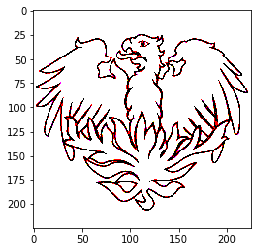

In [294]:
#started by testing this with a pheonix- not using big functions because wanted to check how individal functions work. 
pheonix= Import('pheonix.jpg')
#plt.imshow(pheonix)
pheonix_array = np.array(pheonix)
pheonix_ng = NotGray(120, pheonix)
plt.imshow(pheonix_ng)


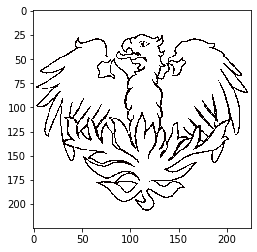

In [295]:
pheonix_bw = CollapseRBG(pheonix_ng)
black_coords_pheonix = black_coords(pheonix_bw)
plt.imshow(pheonix_bw)

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


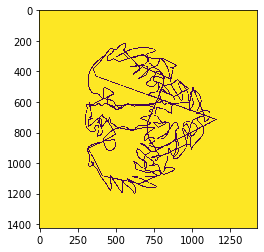

In [97]:
#Parametrizaton of the pheonix
pheonix_x, pheonix_y, pheonix_t, pheonix_param = SetUpPicture('pheonix.jpg', start=3000, thresh_ng=120, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='phil_param', IImport=True, plot_import=True, debug= True)

In [ ]:
#The next block of napoleon was testing big function, I did not take data on this one because I did not like the parametrization.
#most is commetned out because kernel restarted and did not want to import them all again. 

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


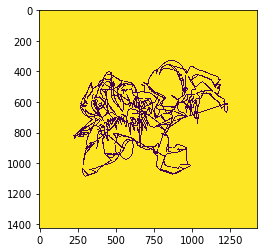

In [18]:
napoleon_x, napoleon_y, napoleon_t, napoleon_param = SetUpPicture('napoleon_rbg.jpg', start=-1, PlotParam=True, evals_line_approx=1000, Save=True, save_plot_as='napoleon_param', IImport=True, plot_import=True, debug= True)

In [19]:
N_vals_1 = np.arange(2, 633, 10) 
N_vals_3 = np.arange(730, 1231, 10)
N_vals_4 = np.arange(640, 730, 10)



In [50]:
#N_vals_1 = np.arange(2, 633, 10) 
#N_vals_2 = np.arange(30, 631, 100)
#N_vals = np.concatenate((N_vals_1, N_vals_2))
#N_vals_3 = np.arange(630, 1230, 100)
#napoleon_big_array = []
#for n in N_vals_1:
#    name = 'napoleon' + str(n)
#    list_n = PreformFourier(napoleon_x, napoleon_y, napoleon_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    napoleon_big_array.append(list_n)
    #print(n, 'is done')
#print(napoleon_big_array)

In [51]:
##N_vals_3 = np.arange(730, 1231, 10)
#napoleon_big_array_3 = []
#for n in N_vals_3:
#    name = 'napoleon' + str(n)
##    list_n = PreformFourier(napoleon_x, napoleon_y, napoleon_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    napoleon_big_array_3.append(list_n)
#    print(n, 'is done')


In [52]:
#N_vals_4 = np.arange(640, 730, 10)
##napoleon_big_array_4 = []
#for n in N_vals_4:
#    name = 'napoleon' + str(n)
#    list_n = PreformFourier(napoleon_x, napoleon_y, napoleon_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    napoleon_big_array_4.append(list_n)
#    print(n, 'is done')

In [53]:
#napoleon_to_1230 = np.concatenate((napoleon_big_array, napoleon_big_array_3))
#napoleon_to_1230 = np.concatenate((napoleon_to_1230, napoleon_big_array_4))
#print(len(napoleon_to_1230))

In [364]:
#precent_sim = np.zeros([len(napoleon_to_1230)])
#for i in range(len(napoleon_to_1230)):
#    pre = ImageDetector(napoleon_param, napoleon_to_1230[i])
 #   precent_sim[i] = pre
    #print(i, 'is done')



In [54]:
#plt.imshow(napoleon_to_1230[-4])

In [55]:
#plt.imshow(napoleon_param)

In [56]:
#ImageDetector(napoleon_param, napoleon_to_1230[-4])

In [98]:
N_to_1600 = np.concatenate((np.arange(2,633,10), np.arange(640, 1601, 10)))

N_to_1230 = np.concatenate((np.arange(2,633,10), np.arange(640, 1231, 10)))


In [ ]:
##NOw the fun stuff! made parametrization of girl 

In [ ]:
#this param made at m=1000

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


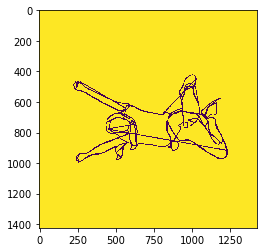

In [58]:
girl_x, girl_y, girl_t, girl_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='girl_param', IImport=True, plot_import=True, debug= True)

In [ ]:
#Imported the ones that I had done FT on. (see the next m level for example of how this worked)
#to redo youcould just import the photos from the git hub repo

In [99]:
girl_big_array = []
for n in N_to_1230:
    name = 'girl' + str(n)
    list_n = JustImport(save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_big_array.append(list_n)

In [100]:
#this takes precent sim to each on and makes an array that we can plot against N_to_1230
girl_precent_sim = np.zeros([len(N_to_1230)])
for i in range(len(N_to_1230)):
    pre = ImageDetector(girl_param, girl_big_array[i])
    girl_precent_sim[i] = pre
    #print(i, 'is done')

In [183]:
#Just checking thins
girl_255 = np.full((np.shape(girl_param)),255)
print(np.shape(girl))

precent_sim_255 = ImageDetector(girl_param, girl_255)
print(precent_sim_255)


(1425, 1425)
0.9665014465989535


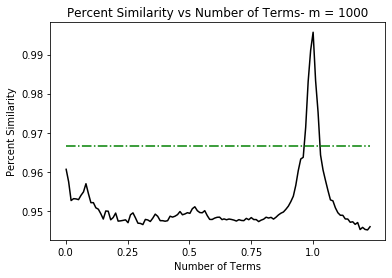

In [438]:
#plotting it!
plt.plot(N_to_1230, girl_precent_sim, 'k-')
#plt.suptitle('Girl')
plt.title('Percent Similarity vs Number of Terms- m = 1000')
plt.xlabel('Number of Terms')
plt.ylabel('Percent Similarity')
plt.plot((0,1230), (precent_sim_255,precent_sim_255), 'g-.')
#plt.plot(N_to_1230, precent_sim, 'r.')
plt.xticks(np.arange(0, 1231,250 ), np.arange(0,2.3, .25))#this renames x as multiples of m
plt.savefig('girl_plot', dpi=95,pad_inches=.1)



import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


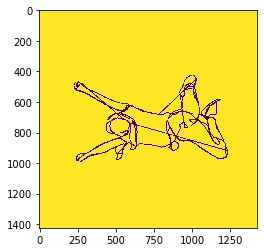

In [83]:
#now repeat what we just did for m=500
girl_x_500, girl_y_500, girl_t_500, girl_param_500 = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=500, Save=True, save_plot_as='girl_param_500', IImport=True, plot_import=True, debug= True)

In [63]:
#this is how we did PReform FOurier
#N_1240_to_1600 = np.arange(1240, 1601,10)
#for n in N_1240_to_1600:
#    name = 'girl_500_' + str(n)
#    list_n = PreformFourier(girl_x_500, girl_y_500, girl_t_500,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
#    girl_big_array_500.append(list_n)
#    print(n, 'is done')

In [78]:
#had to import these again 
girl_big_array_500 = []
for n in N_to_1600:
    name = 'girl_500_' + str(n)
    list_n = JustImport(save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_big_array_500.append(list_n)
    

In [415]:
#here I extend range of m evaluated
list_500_1500 = PreformFourier(girl_x_500, girl_y_500, girl_t_500,n,Save=True, save_plot_as='girl_500_1500', IImport=True,plot_import=False, debug=False)
girl_500__1500_precent_sim = ImageDetector(girl_param_500, list_500_1500)

In [416]:
print(girl_500__1500_precent_sim)

0.9486980609418283


In [84]:
#tookprecent sim for each approx at m=500
girl_500_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(girl_param_500, girl_big_array_500[i])
    girl_500_precent_sim[i] = pre

In [188]:
precent_sim_255_500 = ImageDetector(girl_param_500, girl_255)


([<matplotlib.axis.XTick at 0x17cb6317198>,
 <a list of 7 Text xticklabel objects>)

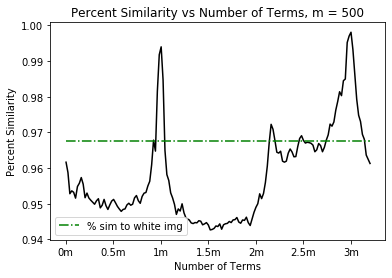

In [299]:
#plotted it all! m=500
plt.plot(N_to_1600, girl_500_precent_sim, 'k-')
plt.plot((0,1600), (precent_sim_255_500,precent_sim_255_500), 'g-.', label='% sim to white img')
#plt.suptitle('Girl')
plt.title('Percent Similarity vs Number of Terms, m = 500')
plt.xlabel('Number of Terms')
plt.ylabel('Percent Similarity')
plt.legend(loc='lower left')
plt.savefig('girl_500_plot', dpi=95,pad_inches=.1)
plt.xticks(np.arange(0, 1501,250 ), ('0m', '0.5m','1m', '1.5m', '2m', '2.5m',  '3m'))

import done
not_grey done
collapseRBG done
black_coords found
6400
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


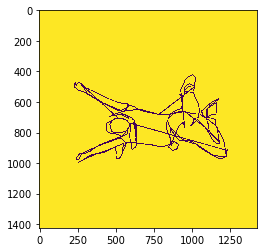

In [232]:
#now for 250
girl_x_250, girl_y_250, girl_t_250, girl_250_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=250, Save=True, save_plot_as='girl_250_param', IImport=True, plot_import=True, debug= True)

In [107]:
#same deal 
girl_array_250 = []
for n in N_to_1600:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_array_250.append(list_n)

In [160]:
N_1600_to_1900 = np.arange(1610, 1901, 10)

In [161]:
#wanted to extend range to 1900
girl_array_250_addon = []
for n in N_1600_to_1900:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_array_250_addon.append(list_n)

In [398]:
#list_250_250 =PreformFourier(girl_x_250, girl_y_250, girl_t_250,250,Save=True, save_plot_as='girl_250_250', IImport=True,plot_import=False, debug=False)
#this was perlim checking expected max
list_250_2250 =PreformFourier(girl_x_250, girl_y_250, girl_t_250,2250,Save=True, save_plot_as='girl_250_2250', IImport=True,plot_import=False, debug=False)

In [402]:
#now checking around expected max further out N=2750
list_250_2750 =PreformFourier(girl_x_250, girl_y_250, girl_t_250,2750,Save=True, save_plot_as='girl_250_2750', IImport=True,plot_import=False, debug=False)

In [403]:
#checking sim further out N=2750
girl_250__2750_precent_sim = ImageDetector(girl_250_param, list_250_2750)


In [408]:
#same for N-3250
list_250_3250 =PreformFourier(girl_x_250, girl_y_250, girl_t_250,3250,Save=True, save_plot_as='girl_250_32500', IImport=True,plot_import=False, debug=False)
girl_250__3250_precent_sim = ImageDetector(girl_250_param, list_250_3250)

In [410]:

list_250_3750 =PreformFourier(girl_x_250, girl_y_250, girl_t_250,3750,Save=True, save_plot_as='girl_250_3750', IImport=True,plot_import=False, debug=False)
girl_250__3750_precent_sim = ImageDetector(girl_250_param, list_250_3750)

In [404]:
print(girl_250__2750_precent_sim)

0.9962100338565713


In [276]:
#here making approxs at higher ranges of N with m=250
Need = [125, 375,500,625,750,875,1000,1125,1250,1375,1500,1625,1750,1875]
girl_250_Need=[]
for n in Need:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_250_Need.append(list_n)

In [420]:
#even larger N, smaller step size
More = np.arange(2000, 4251, 50)
girl_250_More=[]
for n in More:
    name = 'girl_250_' + str(n)
    list_n =PreformFourier(girl_x_250, girl_y_250, girl_t_250,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_250_More.append(list_n)

In [421]:
#taking precent diff further out
girl_250_precent_sim_More = np.zeros([len(More)])
for i in range(len(More)):
    pre = ImageDetector(girl_250_param, girl_250_More[i])
    girl_250_precent_sim_More[i] = pre

In [268]:
girl_250__250_precent_sim = ImageDetector(girl_250_param, list_250_250)

In [278]:
#precent sim for first extension
girl_250_precent_sim_Need = np.zeros([len(Need)])
for i in range(len(Need)):
    pre = ImageDetector(girl_250_param, girl_250_Need[i])
    girl_250_precent_sim_Need[i] = pre

In [162]:
#precent sim for second extension
girl_250_precent_sim_addon = np.zeros([len(N_1600_to_1900)])
for i in range(len(N_1600_to_1900))
    pre = ImageDetector(girl_250_param, girl_array_250_addon[i])
    girl_250_precent_sim_addon[i] = pre


In [140]:
##Girl 250 finding percent similarity for OG range
girl_250_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(girl_250_param, girl_array_250[i])
    girl_250_precent_sim[i] = pre

In [165]:
girl_250_precent_sim_1900 = np.concatenate((girl_250_precent_sim, girl_250_precent_sim_addon))
N_vals_1900 = np.concatenate((N_to_1600, N_1600_to_1900))

In [193]:
precent_sim_255_250 = ImageDetector(girl_250_param, girl_255)

<IPython.core.display.Javascript object>


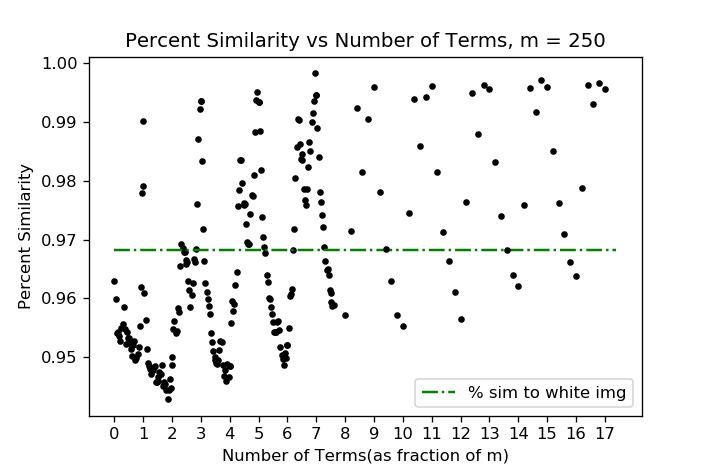

[   2   12   22   32   42   52   62   72   82   92  102  112  122  132
  142  152  162  172  182  192  202  212  222  232  242  252  262  272
  282  292  302  312  322  332  342  352  362  372  382  392  402  412
  422  432  442  452  462  472  482  492  502  512  522  532  542  552
  562  572  582  592  602  612  622  632  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110
 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250
 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390
 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530
 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670
 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810
 1820 1830 1840 1850 1860 1870 1880 1890 1900]


In [512]:
#Plotting all for m=250
#%matplotlib notebook
plt.plot(N_vals_1900, girl_250_precent_sim_1900, 'k.')
plt.plot((0,4350), (precent_sim_255_250,precent_sim_255_250), 'g-.',label='% sim to white img')
plt.plot(250,girl_250__250_precent_sim, 'k.')
plt.plot(Need, girl_250_precent_sim_Need, 'k.')
plt.plot(More, girl_250_precent_sim_More,'k.')
plt.title('Percent Similarity vs Number of Terms, m = 250')
plt.xlabel('Number of Terms(as fraction of m)')
plt.ylabel('Percent Similarity')
plt.legend(loc='lower right')
#plt.savefig('girl_250_plot', dpi=95,pad_inches=.1)
plt.xticks(np.arange(0, 4350,250 ), np.arange(0, 20, 1))
print(N_vals_1900)

<IPython.core.display.Javascript object>


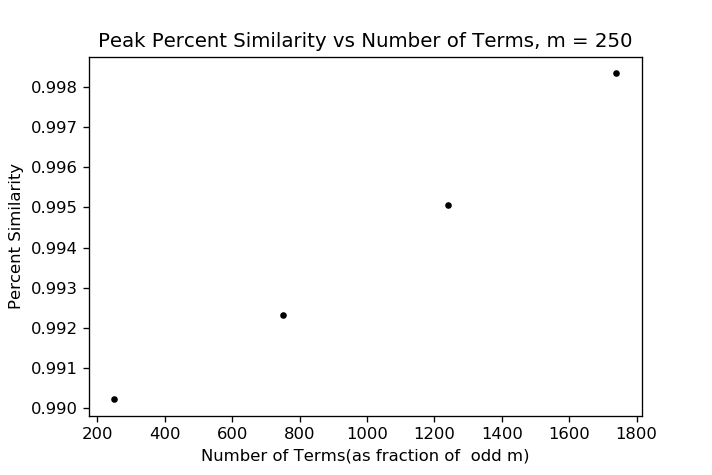

In [495]:
#plottning the highest peaks for first 4 periods
x_vals = (250, 750, 1240, 1740)
precent =girl_250_precent_sim_1900
numbers = N_vals_1900
five = np.where(numbers==582)[0][0]
seven = np.where(numbers==740)[0][0]
ten = np.where(numbers==1090)[0][0]
twelve = np.where(numbers==1240)[0][0]
fifteen = np.where(numbers==1590)[0][0]
seventeen =np.where(numbers==1740)[0][0]
y_vals = (girl_250__250_precent_sim,  precent[seven],  precent[twelve], precent[seventeen])
plt.plot(x_vals,y_vals, 'k.')
plt.title('Peak Percent Similarity vs Number of Terms, m = 250')
plt.xlabel('Number of Terms(as fraction of  odd m)')
plt.ylabel('Percent Similarity')
dy = (.001, .001, .001, .001)

<IPython.core.display.Javascript object>


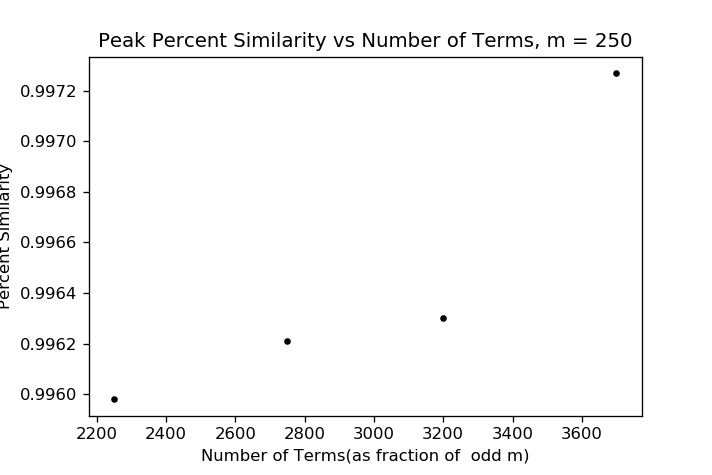

In [501]:
#doing same for next 4 periods
xx_vals = (2250, 2750, 3200, 3700)
precent =girl_250_precent_sim_More
numbers = More
#print(np.shape(precent))
five = np.where(numbers==2250)[0][0]
#print(five)
seven = np.where(numbers==2750)[0][0]
#print(seven)
ten = np.where(numbers==3200)[0][0]
#print(ten)
twelve = np.where(numbers==3700)[0][0]
#print(twelve)
fifteen = np.where(numbers==4200)[0][0]
#print(fifteen)

yy_vals = (precent[five], precent[seven], precent[ten], precent[twelve])
#print(np.shape(y_vals))
plt.plot(xx_vals, yy_vals, 'k.')
plt.title('Peak Percent Similarity vs Number of Terms, m = 250')
plt.xlabel('Number of Terms(as fraction of  odd m)')
plt.ylabel('Percent Similarity')
dyy = (.001, .001, .001, .001)


In [502]:
#this is for fitting linear fit
from scipy import optimize
def linear(p, xvar):                                           #This will define a generic linear function- I will keep this
    return p[0] + p[1]*xvar
def linear_residual(p, xvar, yvar, err):                       #This will be an imput for our least squares method
    return (linear(p, xvar) - yvar)/err
array = [1.,1.]
def LinearFit(guess, x, y, dy, title, axisx, axisy, B, output=False):
    guess = array
    pf, cov, info, mesg, success = optimize.leastsq(linear_residual, guess,
                                                args=(x, y, dy), full_output=1)
    print('one')
    # If the fit failed, print the reason
    if cov is None:
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
    else:
        print(len(pf))
        chisq = sum(info['fvec']*info['fvec'])
        dof = len(x) - len(pf)
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        epsilon = (pf[0]/pf[1])+1
        depsilon = (epsilon)*((pferr[0]/pf[0])**2 + (pferr[1]/pf[1])**2)**(.5)
        print('Converged with chi-squared', chisq)
        print('Number of degrees of freedom, dof =', dof)
        print('Reduced chi-squared ', chisq/dof)
        print('Inital guess values:')
        print('  p0 =', guess)
        print('Best fit values:')
        print('  pf =', pf)
        print('  epsilon =', epsilon)
        print('Uncertainties in the best fit values:')
        print('  pferr =', pferr)
        print('  depsilon =', depsilon) 
             
    fig = plt.figure()
   
    ax = fig.add_subplot(111)
    plt.setp(ax, xticks=np.arange(0, 1901,250 ), xticklabels=np.arange(0,7.6, 1))
    ax.errorbar(x, y, dy, fmt='ko', label = 'Data')
    X = np.linspace(x.min(), x.max(), 500)
    ax.plot(X, linear(pf, X), 'r-', label = 'Linear Fit')
    #ax.xticks(np.arange(0, 1901,125 ), ('0', '0.5','1', '1.5', '2', '2.5',  '3', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5'))
    ax.set_title(title)
    ax.set_xlabel(axisx)
    ax.set_ylabel(axisy)
    ax.legend(loc='lower right')
    
     # Here is the text we want to include...
    textfit = '$y = mx+b $\n' \
              '$b = %.2f \pm %.2f$ \n' \
              '$m = %.1e \pm %.0e$ \n' \
              '$\chi^2= %.1f$ \n' \
              '$N = %i$ (dof) \n' \
              '$\chi^2/N = % .2f$' \
               % (pf[0], pferr[0], pf[1], pferr[1],
               chisq, dof, chisq/dof)
    #... and below is where we actually place it on the plot
    ax.text(0.05, 0.95, textfit , transform=ax.transAxes, fontsize=12,
            verticalalignment='top')
    #textfit2 = '$m = % $\n' \
     #           % (B)
   # ax.text(.7, .05,  textfit2 ,transform=ax.transAxes, fontsize=12,
    #          verticalalignment='top')
    #ax.set_xlim([x.min()-50, x.max()+50])
       # plt.savefig('Example2_Figure1.pdf')
    plt.show()
    if output== True:
        return [pf, pferr]

one
2
Converged with chi-squared 0.3514096065094835
Number of degrees of freedom, dof = 2
Reduced chi-squared  0.17570480325474175
Inital guess values:
  p0 = [1.0, 1.0]
Best fit values:
  pf = [9.88532667e-01 5.48181454e-06]
  epsilon = 180330.4619712679
Uncertainties in the best fit values:
  pferr = [0.0010270504199038116, 9.016329203789486e-07]
  depsilon = 29660.821894376986


<IPython.core.display.Javascript object>


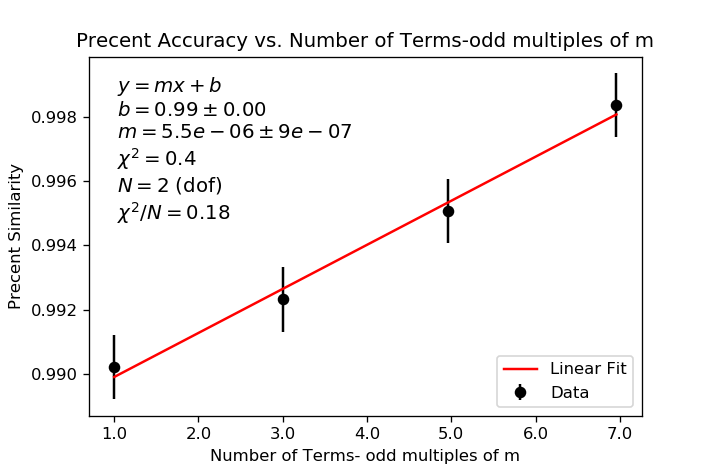

In [498]:
#fitting lien to first four peaks
LinearFit(guess, np.array(x_vals), np.array(y_vals), np.array(dy), 'Precent Accuracy vs. Number of Terms-odd multiples of m', 'Number of Terms- odd multiples of m', 'Precent Similarity', 250, output=False)

one
2
Converged with chi-squared 0.17954823296231193
Number of degrees of freedom, dof = 2
Reduced chi-squared  0.08977411648115596
Inital guess values:
  p0 = [1.0, 1.0]
Best fit values:
  pf = [9.93972397e-01 8.29533236e-07]
  epsilon = 1198231.9497782697
Uncertainties in the best fit values:
  pferr = [0.0028159437124606903, 9.314956073456493e-07]
  depsilon = 1345517.3363071864


<IPython.core.display.Javascript object>


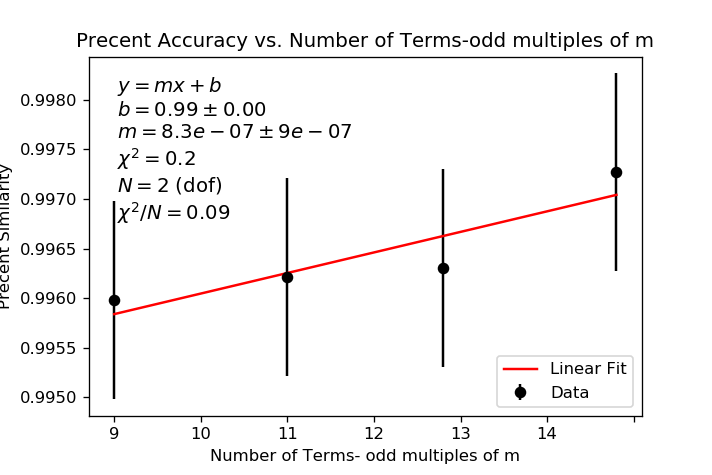

([<matplotlib.axis.XTick at 0x17c806f9cf8>,
 <a list of 6 Text xticklabel objects>)

In [513]:
#fitting line to second 4 peaks
LinearFit(guess, np.array(xx_vals), np.array(yy_vals), np.array(dyy), 'Precent Accuracy vs. Number of Terms-odd multiples of m', 'Number of Terms- odd multiples of m', 'Precent Similarity', 250, output=False)
plt.xticks(np.arange(2250, 3900, 250), np.arange(9,15,1))


In [274]:
#print(np.abs(fft_precent_sim[15:]))
where =np.where(girl_250_precent_sim_1900 >.97)
#for i in where[0]:
    #print(i)
    #print(N_vals_1900[i], girl_250_precent_sim_1900[i])
freq_vals = np.arange(0, 1901, 125)  


In [247]:
print(girl_250_precent_sim_1900[int(precent_sim_255_250])


0.9629114188981225


import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


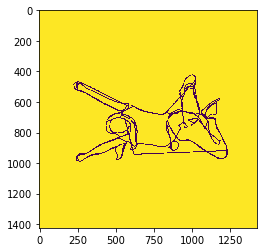

In [146]:
#Now doing same for 750 you get the picture. 
girl_x_750, girl_y_750, girl_t_750, girl_750_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=False, evals_line_approx=750, Save=True, save_plot_as='girl_750_param', IImport=True, plot_import=True, debug= True)

In [143]:
girl_array_750 = []
for n in N_to_1600:
    name = 'girl_750_' + str(n)
    list_n =PreformFourier(girl_x_750, girl_y_750, girl_t_750,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    girl_array_750.append(list_n)

In [148]:
girl_750_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(girl_750_param, girl_array_750[i])
    girl_750_precent_sim[i] = pre

In [195]:
precent_sim_255_750 = ImageDetector(girl_750_param, girl_255)

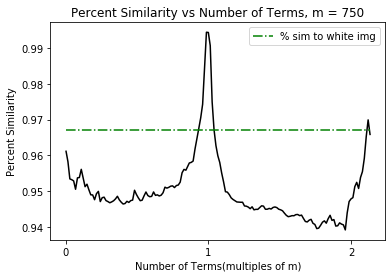

In [439]:
plt.plot(N_to_1600, girl_750_precent_sim, 'k-')
plt.plot((0,1600), (precent_sim_255_750,precent_sim_255_750), 'g-.',label='% sim to white img')
plt.title('Percent Similarity vs Number of Terms, m = 750')
#plt.suptitle('Girl')
plt.xlabel('Number of Terms(multiples of m)')
plt.ylabel('Percent Similarity')
plt.legend(loc = 'best')
plt.xticks(np.arange(0, 1501,750 ), np.arange(0,5,1))
plt.savefig('girl_750_plot', dpi=95,pad_inches=.1)

In [86]:
N_to_1610 = np.arange(2, 1611, 10)

import done
not_grey done
collapseRBG done
black_coords found
path found
lineapprox done
saveplot done
import done
imported collapse RBGA done
NotGrey01 done


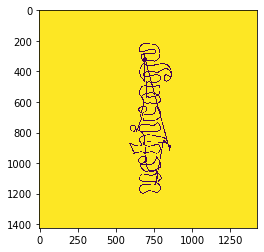

In [135]:
#on last one for fun: the uchicago picture
uc_x, uc_y, uc_t, uc_param = SetUpPicture('uchicago.jpg', start=-615, thresh_ng=200, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='uc_param', IImport=True, plot_import=True, debug= True)

In [110]:
uc_array_1000 = []
for n in N_to_1600:
    name = 'uc_1000_' + str(n)
    list_n =PreformFourier(uc_x, uc_y, uc_t,n,Save=True, save_plot_as=name, IImport=True,plot_import=False, debug=False)
    uc_array_1000.append(list_n)

In [136]:
##UCHICAGO finding percent similarity
uc_1000_precent_sim = np.zeros([len(N_to_1600)])
for i in range(len(N_to_1600)):
    pre = ImageDetector(uc_param, uc_array_1000[i])
    uc_1000_precent_sim[i] = pre
    

Text(0, 0.5, 'Percent Similarity')

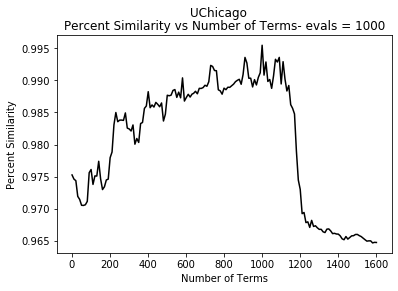

In [137]:
#only plottd to N=m, dont get to see N=3m etc. 
plt.plot(N_to_1600, uc_1000_precent_sim, 'k-')
plt.title('Percent Similarity vs Number of Terms- evals = 1000')
plt.suptitle('UChicago')
plt.xlabel('Number of Terms')
plt.ylabel('Percent Similarity')

In [ ]:
girl_x_250, girl_y_250, girl_t_250, girl_250_param = SetUpPicture('girl.jpg', start=-1, thresh_ng=20, PlotParam=True, evals_line_approx=250, Save=True, save_plot_as='girl_param', IImport=True, plot_import=False, debug= True)

In [ ]:
uc_x, uc_y, uc_t, uc_param = SetUpPicture('uchicago.jpg', start=-615, thresh_ng=200, PlotParam=False, evals_line_approx=1000, Save=True, save_plot_as='uc_param', IImport=True, plot_import=True, debug= True)

In [150]:
ImageDetector(girl_param, girl_250_param)

0.9758044936903663

In [152]:
ImageDetector(girl_param, girl_param_500)

0.9821188057863958

In [154]:
ImageDetector(girl_param, girl_750_param)

0.9861254539858418

In [155]:
ImageDetector(girl_param, girl_param)

1.0